In [2]:
print("hello world")

hello world


In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms

## 1. Structure des données

- Dossiers : Evaluation-Set/Validation/ & Evaluation-Set/Validation_Labels.csv, Training-Set/Training/ & Training-Set/Training_Labels.csv
- Images : Chaque image a un ID correspondant à son nom (ex: 1.png → ID 1). L'image Validation/1.png != Training/1.png
- CSV : Chaque ligne du CSV correspond à une image, avec l'ID en première colonne et les labels en colonnes suivantes.

## 2. Classe personnalisée pour le chargement des données


In [4]:
class RetinaDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        """
        Args:
            root_dir (string): Dossier contenant les images.
            csv_file (string): Chemin vers le fichier CSV contenant les labels.
            transform (callable, optional): Transformations à appliquer sur les images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.labels_df = pd.read_csv(csv_file)
        # On suppose que l'ID est la première colonne et que les labels commencent à la 3ème colonne (ex: DR, ARMD, etc.)
        self.labels = self.labels_df.iloc[:, 2:].values  # On ignore la 2ème colonne (Disease_Risk) car elle n'est pas un label
        self.image_ids = self.labels_df.iloc[:, 0].values  # ID des images

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, f"{self.image_ids[idx]}.png")
        image = Image.open(img_name).convert('RGB')  # Charge l'image en RGB
        label = self.labels[idx]
        label = torch.FloatTensor(label)  # Convertit le label en tenseur

        if self.transform:
            image = self.transform(image)

        return image, label

## 3. Définir les transformations

In [5]:
def crop_image_tensor(img_tensor):
    _, w, h = img_tensor.shape
    # Si l'image est en haute résolution (4288x2848)
    if h == 4288 and w == 2848:
        # Rogner à gauche de 260 pixels et à droite de 600 pixels
        return img_tensor[:, :, 260:-600]
    # Si l'image est en résolution standard (2144x1424)
    elif h == 2144 and w == 1424:
        # Rogner normalement (360 pixels de chaque côté)
        return img_tensor[:, :, 360:-360]
    elif h == 2048 and w == 1536:
        # Rogner à gauche de 260 pixels et à droite de 600 pixels
        return img_tensor[:, :, 280:-280]
    else:
        # Si la taille ne correspond à aucun cas connu, retourner l'image non rognée
        print(f"Taille inattendue : {h}x{w}")
        return img_tensor


In [6]:
# Appliquer les transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop_image_tensor),
    transforms.Resize((512, 512)),  # Redimensionne l'image après rognage
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


### Test de la fonction de rognage des images

In [7]:
# # Charger l'image originale
# image = Image.open(os.path.join(r'../data/Training_Set/Training/', '1.png')).convert('RGB')

# # Afficher l'image originale
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(image)
# plt.title("Image originale")
# plt.axis('off')

# # Appliquer les transformations
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Lambda(crop_image_tensor),
#     transforms.Resize((1424, 1424)),  # Redimensionne l'image après rognage
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# cropped_image = transform(image)

# # Afficher l'image rognée
# plt.subplot(1, 2, 2)
# plt.imshow(cropped_image.permute(1, 2, 0))  # Convertir de [C,H,W] à [H,W,C]
# plt.title(f"Image rognée{cropped_image.shape}")
# plt.axis('off')

# plt.tight_layout()
# plt.show()

In [8]:
# # Charger l'image originale
# image = Image.open(os.path.join(r'../data/Training_Set/Training/', '380.png')).convert('RGB')

# # Afficher l'image originale
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(image)
# plt.title("Image originale")
# plt.axis('off')

# # Appliquer les transformations
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Lambda(crop_image_tensor),
#     transforms.Resize((1424, 1424)),  # Redimensionne l'image après rognage
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# cropped_image = transform(image)

# # Afficher l'image rognée
# plt.subplot(1, 2, 2)
# plt.imshow(cropped_image.permute(1, 2, 0))  # Convertir de [C,H,W] à [H,W,C]
# plt.title(f"Image rognée{cropped_image.shape}")
# plt.axis('off')

# plt.tight_layout()
# plt.show()

In [9]:
# # Charger l'image originale
# image = Image.open(os.path.join(r'../data/Training_Set/Training/', '488.png')).convert('RGB')

# # Afficher l'image originale
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(image)
# plt.title("Image originale")
# plt.axis('off')

# # Appliquer les transformations
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Lambda(crop_image_tensor),
#     transforms.Resize((1424, 1424)),  # Redimensionne l'image après rognage
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# cropped_image = transform(image)

# # Afficher l'image rognée
# plt.subplot(1, 2, 2)
# plt.imshow(cropped_image.permute(1, 2, 0))  # Convertir de [C,H,W] à [H,W,C]
# plt.title(f"Image rognée{cropped_image.shape}")
# plt.axis('off')

# plt.tight_layout()
# plt.show()

## 4. Charger les jeux de données


In [ ]:
train_dataset = RetinaDataset(
    root_dir='../../data/Training-Set/Training',
    csv_file='../../data/Training-Set/Training_Labels.csv',
    transform=transform
)

val_dataset = RetinaDataset(
    root_dir='../../data/Evaluation-Set/Validation',
    csv_file='../../data/Evaluation-Set/Validation_Labels.csv',
    transform=transform
)


In [11]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0
)


### Vérification rapide du bon chargement des données

In [12]:
# import matplotlib.pyplot as plt

# def imshow(img):
#     img = img.numpy().transpose((1, 2, 0))
#     mean = [0.485, 0.456, 0.406]
#     std = [0.229, 0.224, 0.225]
#     img = std * img + mean
#     img = np.clip(img, 0, 1)
#     plt.imshow(img)
#     plt.show()

# # Exemple d'affichage
# images, labels = next(iter(train_loader))
# imshow(images[0])
# print("Labels:", labels[0])


## 5. Définir l'architecture du modèle

In [13]:
NUMBER_OF_CLASSES = 45  # 45 maladies possibles

class RetinaCNN(nn.Module):
    def __init__(self):
        super(RetinaCNN, self).__init__()
        # Couches convolutives
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # (16, 512, 512)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)  # (16, 256, 256)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # (32, 256, 256)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)  # (32, 128, 128)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (64, 128, 128)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)  # (64, 64, 64)

        # Couches fully connected
        self.fc1 = nn.Linear(64 * 64 * 64, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, NUMBER_OF_CLASSES)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, 64 * 64 * 64)  # Aplatir
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid pour multi-label
        return x

In [14]:
# Initialisation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RetinaCNN().to(device)

## 6. Fonction de perte et métriques

In [15]:
criterion = nn.BCEWithLogitsLoss() # ou alternative nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 7. Entrainement du modèle

### A. Paramétrage

In [ ]:
# Early stopping
patience = 5  # Nombre d'epochs sans amélioration avant d'arrêter
min_delta = 0.001  # Différence minimale pour considérer une amélioration
best_val_loss = float('inf')
counter = 0

# Stockage des métriques
training_statistics = {
    'epoch': [],
    'train_losses': [],
    'val_losses': [],
    'train_accuracies': [],
    'val_accuracies': [],
    'val_f1s': [],
    'train_f1s': []}

num_epochs = 20  # Nombre maximal d'epochs

### B. Entrainement

In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch number: {epoch}")
    training_statistics['epoch'].append(epoch)
    model.train()
    running_loss = 0.0
    train_preds = []
    train_targets = []

    # Entraînement 
    for _, all in tqdm(enumerate(train_loader), total=len(train_loader)):
        images, labels = all[0].to(device), all[1].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.sigmoid(outputs) > 0.5
        train_preds.extend(preds.cpu().detach().numpy())
        train_targets.extend(labels.cpu().detach().numpy())

    # Métriques d'entraînement 
    train_loss = running_loss / len(train_loader)
    train_accuracy = accuracy_score(train_targets, train_preds)
    train_f1 = f1_score(train_targets, train_preds, average='micro')
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Train F1-score: {train_f1:.4f}")

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_preds = []
    val_targets = []

    # désaxctiver le calcul des gradients car non nécessaire pour calculer les métriques de validation
    with torch.no_grad(): 
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5
            val_preds.extend(preds.cpu().detach().numpy())
            val_targets.extend(labels.cpu().detach().numpy())

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = accuracy_score(val_targets, val_preds)
    val_f1 = f1_score(val_targets, val_preds, average='micro')
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f} | Val F1-score: {val_f1:.4f}")
    print(f"Mémoire GPU utilisée: {torch.cuda.memory_allocated() / 1024**3:.2f} Go")

    # Early stopping
    if epoch > 5:
        if (best_val_loss - val_loss) > min_delta:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            print(f"Early stopping à l'epoch {epoch}")
            break

    # Stockage des métriques
    training_statistics['train_losses'].append(train_loss)
    training_statistics['train_accuracies'].append(train_accuracy)
    training_statistics['train_f1s'].append(train_f1)
    training_statistics['val_losses'].append(val_loss)
    training_statistics['val_accuracies'].append(val_accuracy)
    training_statistics['val_f1s'].append(val_f1)
    torch.cuda.empty_cache()
    print("="*70)


Epoch number: 0


100%|██████████| 40/40 [03:29<00:00,  5.24s/it]


Train Loss: 0.7108 | Train Accuracy: 0.1387 | Train F1-score: 0.0298
Val Loss: 0.6931 | Val Accuracy: 0.2094 | Val F1-score: 0.0000
Mémoire GPU utilisée: 2.21 Go
Epoch number: 1


100%|██████████| 40/40 [03:08<00:00,  4.70s/it]


Train Loss: 0.6938 | Train Accuracy: 0.1996 | Train F1-score: 0.0021
Val Loss: 0.6931 | Val Accuracy: 0.2094 | Val F1-score: 0.0000
Mémoire GPU utilisée: 2.21 Go
Epoch number: 2


100%|██████████| 40/40 [03:08<00:00,  4.71s/it]


Train Loss: 0.6934 | Train Accuracy: 0.2035 | Train F1-score: 0.0007
Val Loss: 0.6931 | Val Accuracy: 0.2094 | Val F1-score: 0.0000
Mémoire GPU utilisée: 2.21 Go
Epoch number: 3


100%|██████████| 40/40 [03:08<00:00,  4.71s/it]


Train Loss: 0.6934 | Train Accuracy: 0.2062 | Train F1-score: 0.0000
Val Loss: 0.6931 | Val Accuracy: 0.2094 | Val F1-score: 0.0000
Mémoire GPU utilisée: 2.21 Go
Epoch number: 4


100%|██████████| 40/40 [03:07<00:00,  4.68s/it]


Train Loss: 0.6933 | Train Accuracy: 0.2074 | Train F1-score: 0.0007
Val Loss: 0.6931 | Val Accuracy: 0.2094 | Val F1-score: 0.0000
Mémoire GPU utilisée: 2.21 Go
Epoch number: 5


100%|██████████| 40/40 [03:08<00:00,  4.72s/it]


Train Loss: 0.6933 | Train Accuracy: 0.2043 | Train F1-score: 0.0007
Val Loss: 0.6931 | Val Accuracy: 0.2094 | Val F1-score: 0.0000
Mémoire GPU utilisée: 2.21 Go
Epoch number: 6


100%|██████████| 40/40 [03:09<00:00,  4.74s/it]


Train Loss: 0.6933 | Train Accuracy: 0.2062 | Train F1-score: 0.0000
Val Loss: 0.6931 | Val Accuracy: 0.2094 | Val F1-score: 0.0000
Mémoire GPU utilisée: 2.21 Go
Epoch number: 7


100%|██████████| 40/40 [03:08<00:00,  4.70s/it]


Train Loss: 0.6933 | Train Accuracy: 0.2059 | Train F1-score: 0.0000
Val Loss: 0.6931 | Val Accuracy: 0.2094 | Val F1-score: 0.0000
Mémoire GPU utilisée: 2.21 Go
Epoch number: 8


100%|██████████| 40/40 [03:09<00:00,  4.73s/it]


Train Loss: 0.6932 | Train Accuracy: 0.2078 | Train F1-score: 0.0000
Val Loss: 0.6931 | Val Accuracy: 0.2094 | Val F1-score: 0.0000
Mémoire GPU utilisée: 2.21 Go
Epoch number: 9


100%|██████████| 40/40 [03:09<00:00,  4.75s/it]


Train Loss: 0.6932 | Train Accuracy: 0.2078 | Train F1-score: 0.0000
Val Loss: 0.6931 | Val Accuracy: 0.2094 | Val F1-score: 0.0000
Mémoire GPU utilisée: 2.21 Go
Epoch number: 10


100%|██████████| 40/40 [03:07<00:00,  4.69s/it]


Train Loss: 0.6932 | Train Accuracy: 0.2090 | Train F1-score: 0.0007
Val Loss: 0.6931 | Val Accuracy: 0.2094 | Val F1-score: 0.0000
Mémoire GPU utilisée: 2.21 Go
Epoch number: 11


100%|██████████| 40/40 [03:08<00:00,  4.71s/it]


Train Loss: 0.6932 | Train Accuracy: 0.2070 | Train F1-score: 0.0000
Val Loss: 0.6931 | Val Accuracy: 0.2094 | Val F1-score: 0.0000
Mémoire GPU utilisée: 2.21 Go
Early stopping à l'epoch 11


In [ ]:
torch.save(model.state_dict(), './model_retina_cnn.pth')

In [ ]:
training_statistics_df = pd.DataFrame(training_statistics)
training_statistics_df.to_csv('training_statistics.csv', index=False)

In [ ]:
# Charger les métriques sauvegardées
training_statistics_df = pd.read_csv('training_statistics.csv')

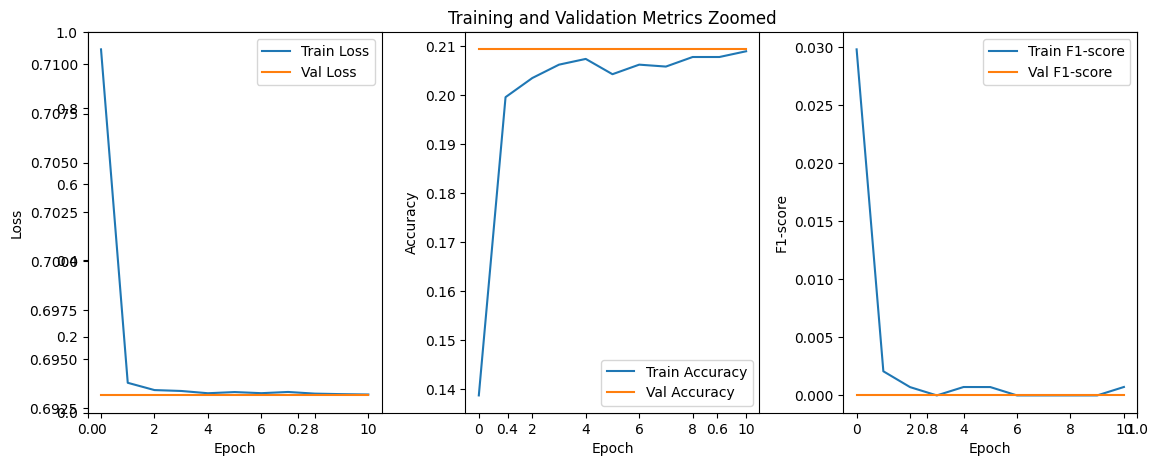

In [ ]:
# Tracer les courbes
plt.figure(figsize=(12, 5))
plt.title('Training and Validation Metrics Zoomed')

# Loss
plt.subplot(1, 3, 1)
plt.plot(training_statistics_df['train_losses'], label='Train Loss')
plt.plot(training_statistics_df['val_losses'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(training_statistics_df['train_accuracies'], label='Train Accuracy')
plt.plot(training_statistics_df['val_accuracies'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# F1-score
plt.subplot(1, 3, 3)
plt.plot(training_statistics_df['train_f1s'], label='Train F1-score')
plt.plot(training_statistics_df['val_f1s'], label='Val F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.legend()


plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()


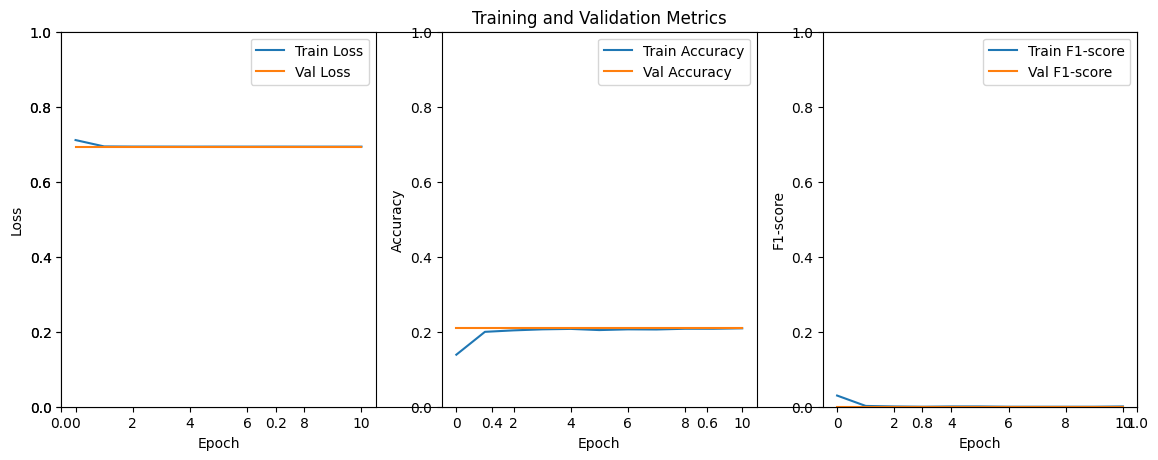

In [ ]:
# Tracer les courbes
plt.figure(figsize=(12, 5))
plt.title('Training and Validation Metrics')

# Loss
plt.subplot(1, 3, 1)
plt.plot(training_statistics_df['train_losses'], label='Train Loss')
plt.plot(training_statistics_df['val_losses'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(training_statistics_df['train_accuracies'], label='Train Accuracy')
plt.plot(training_statistics_df['val_accuracies'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

# F1-score
plt.subplot(1, 3, 3)
plt.plot(training_statistics_df['train_f1s'], label='Train F1-score')
plt.plot(training_statistics_df['val_f1s'], label='Val F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.ylim(0, 1)
plt.legend()


plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()


Results are very bad..